<a href="https://colab.research.google.com/github/anekoss/AI-System/blob/main/lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import random
import seaborn as sns


In [10]:
data = pd.read_csv("/content/DATA (1).csv")

In [11]:
def MyMinMaxScaler(A):
    for i in A.columns:
        maxi = A[i].max()
        mini = A[i].min()
        A[i] = (A[i] - mini) / (maxi - mini)
    return A


def my_train_test_split(X, Y, test_size=0.3):
    X_columns = X.columns
    Y_columns = Y.columns
    X = X.to_numpy()
    Y = Y.to_numpy()
    idxes = np.array(range(len(X)))

    test_size = round(test_size * len(X))

    random.shuffle(idxes)

    train_idx = idxes[test_size:len(X)]
    test_idx = idxes[0:test_size]

    return(pd.DataFrame(X[train_idx, :], columns=X_columns), pd.DataFrame(X[test_idx, :], columns=X_columns), pd.DataFrame(Y[train_idx, :], columns=Y_columns), pd.DataFrame(Y[test_idx, :], columns=Y_columns))


def my_f1_score(y_test, pred):
	#Classes = [TP, FP, TN, FN]
	y_test = np.array(y_test).flatten()
	pred = np.array(pred)
	TP = 0
	FP = 0
	TN = 0
	FN = 0


	classes = list(set(y_test.tolist()))
	classes_stats = [[0, 0, 0, 0]]*len(classes)
	for i, cur_class in enumerate(classes):
		for idx, (el1, el2) in enumerate(zip(y_test, pred)):
			if (el1==el2==cur_class):
				TP+=1
				classes_stats[i][0]+=1
			if (el2==cur_class and el1!=el2):
				FP+=1
				classes_stats[i][1]+=1
			if (el1==el2 and el1!=cur_class):
				classes_stats[i][2]+=1
				TN+=1
			if (el1!=el2 and el1!=cur_class):
				classes_stats[i][3]+=1
				FN+=1

	return TP/(TP + (1/(len(classes))) * (FP + FN))


def my_confusion_matrix(y_test, pred):
	#Classes = [TP, FP, TN, FN]
	y_test = np.array(y_test).flatten()
	pred = np.array(pred)

	classes = list(set(y_test.tolist()))
	num_classes = len(classes)
	confusion_matrix = np.zeros((num_classes, num_classes))
	for true_label, predicted_label in zip(y_test, pred):
		true_label_index = classes.index(true_label)
		predicted_label_index = classes.index(predicted_label)
		confusion_matrix[true_label_index][predicted_label_index] += 1

	return confusion_matrix


def kfold_dtree(X, Y, label, max_depth, min_samples_split):
	df = pd.concat([X.copy(),Y.copy()], axis=1)
	df = df.rename(columns={label: "Label"})
	df = df.reindex(np.random.permutation(df.index))
	df = df.reset_index(drop=True)


	size_of_fold = X.shape[0]//10
	folds = []
	tmp = 0
	for i in range(10):
		folds.append(pd.DataFrame(df.iloc[tmp:(tmp+size_of_fold)]))
		tmp += size_of_fold



	train = []
	test = []
	for i in range(len(folds)):
		tmp1 = []
		tmp2 = []
		for j in range(len(folds)):
			if i==j:
				tmp2.append(folds[i])
			else:
				if(len(tmp1)>0):
					tmp1[0] = pd.concat([tmp1[0], folds[i]])
				else:
					tmp1.append(folds[i])

		train.append(tmp1)
		test.append(tmp2)


	best_n = -1
	best_l_rate = -1
	best_f1 = 0
	curr_f1 = 0


	for n in max_depth:
		for k in min_samples_split:
			curr_f1 = 0
			for i, val in enumerate(train):
				X_train, y_train, X_test, y_test = train[i][0].drop(["Label"], axis=1), train[i][0][["Label"]], test[i][0].drop(["Label"], axis=1), test[i][0][["Label"]]
				model = DecisionTree(max_depth=n, min_samples_split=k)
				model.fit(X_train.to_numpy(), y_train.to_numpy().flatten())
				curr_f1 += my_f1_score(pd.DataFrame(y_test), model.predict(X_test.to_numpy()))
			if(curr_f1/len(train) >= best_f1):
				best_n = n
				best_l_rate = k
				best_f1 = curr_f1/len(train)


	print("Best depth", best_n)
	print("Best min split", best_l_rate)
	return [best_n, best_l_rate]

In [12]:
# samples_amount = 0.7
# random_state = 339106
# train = data.sample(frac=samples_amount, random_state=random_state)
# train_x = train[["GRADE"]]
# train_y = train.drop(["GRADE", "STUDENT ID"], axis=1)
# test = data.drop(train.index, axis=0)
# test_x = test[["GRADE"]]
# test_y = test.drop(["GRADE", "STUDENT ID"], axis=1)
# cols = X.sample(n = int(len(X.columns) ** 0.5), axis='columns')


In [13]:
class Node:
    def __init__(self, feature=None, children=None, value=None, typenode=None, threshold=None):
        self.feature = feature
        self.threshold = threshold
        self.children = children
        self.value = value
        self.typenode = typenode

    def set_leaf(self):
        self.typenode = "leaf"

    def is_leaf(self):
        return self.typenode == "leaf"


class DecisionTree:
    def __init__(self, max_depth=10, min_features_split=1, min_samples_split=10, n_features=None):
        self.max_depth = max_depth
        self.min_features_split = min_features_split
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.root = None

    def _create_path(self, X, y, current_depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # Checking for ending criteria:
        if ( n_feats < self.min_features_split or n_labels == 1):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value, typenode="leaf")

        # Else
        # We're gonna split all our values and check their quality later...
        feats_idx = np.random.choice(n_feats, self.n_features, replace=False)
        best_feature, best_thresholds = self._best_split(X, y, feats_idx)
        children_split = self._split(X[:, best_feature], best_thresholds)
        children = []

        for i, el in enumerate(children_split):
            children.append(self._create_path(
                X[el, :], y[el], current_depth + 1))

        return Node(feature=best_feature, threshold=best_thresholds, children=children)

    def _best_split(self, X, y, feats_idx):
        best_gain = - 101
        split_idxs = None
        split_thresholds = None

        for feat_idx in feats_idx:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            gain = self._information_gain(y, X_column, thresholds)

            if gain > best_gain:
                best_gain = gain
                split_thresholds = thresholds
                split_idxs = feat_idx

        return split_idxs, split_thresholds

    def _split(self, X_column, thresholds):
        split_data = []
        for i, j in enumerate(thresholds):
            tmp = (np.argwhere(X_column == j).flatten())
            if len(tmp) > 0:
                split_data.append(tmp)
        return split_data.copy()

    def _most_common_label(self, y):
        if (not len(y)):
            print("0 length detected returned 0")
            return 0
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def _information_gain(self, y, X_column, thresholds):
        # parent entropy
        parent_entropy = self._entropy(y)
        n = len(y)
        n_children = []
        e_children = []
        child_entropy = 0

        # create children
        children = self._split(X_column, thresholds)

        for i, el in enumerate(children):
            if not len(el):
                return 0
            n_children.append(len(el))
            e_children.append(self._entropy(y[el]))

            child_entropy += n_children[i] / n * e_children[i]

        # calculate the IG

        information_gain = parent_entropy - child_entropy
        return information_gain

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p > 0])

    def fit(self, X, y):
        if(self.n_features):
            self.n_features = min(X.shape[1], self.n_features)
        else:
            self.n_features = X.shape[1]

        self.root = self._create_path(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value

        child_node = None
        for child in node.children:
            if x[node.feature] == child.feature:
                child_node = child
                break

        if child_node:
            return self._traverse_tree(x, child_node)
        return self._traverse_tree(x, node.children[0])

In [14]:

def auc_roc(y_true, y_scores):
    sorted_indices = np.argsort(y_scores)
    sorted_labels = y_true[sorted_indices]
    num_positives = np.sum(sorted_labels == 1)
    num_negatives = np.sum(sorted_labels == 0)

    tpr = []
    fpr = []

    tp, fp = 0, 0

    for i in range(len(sorted_indices) - 1, -1, -1):
        if sorted_labels[i] == 1:
            tp += 1
        else:
            fp += 1
        tpr.append(tp / num_positives)
        fpr.append(fp / num_negatives)

    return fpr, tpr

def auc_pr(y_true, y_scores):
    sorted_indices = np.argsort(y_scores)[::-1]
    sorted_labels = y_true[sorted_indices]

    precision = []
    recall = []

    tp, fp = 0, 0

    for i in range(len(sorted_indices)):
        if sorted_labels[i] == 1:
            tp += 1
        else:
            fp += 1
        precision.append(tp / (tp + fp))
        recall.append(tp / np.sum(sorted_labels == 1))

    return recall, precision

     1  2  3  4  5  6  7  8  9  10  ...  22  23  24  25  26  27  28  29  30  \
0    2  2  3  3  1  2  2  1  1   1  ...   1   1   1   3   2   1   2   1   1   
1    2  2  3  3  1  2  2  1  1   1  ...   1   1   1   3   2   3   2   2   3   
2    2  2  2  3  2  2  2  2  4   2  ...   1   1   1   2   2   1   1   2   2   
3    1  1  1  3  1  2  1  2  1   2  ...   1   1   2   3   2   2   1   3   2   
4    2  2  1  3  2  2  1  3  1   4  ...   1   2   1   2   2   2   1   2   2   
..  .. .. .. .. .. .. .. .. ..  ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
140  2  1  2  3  1  1  2  1  1   2  ...   1   1   1   2   1   2   1   3   3   
141  1  1  2  4  2  2  2  1  4   2  ...   2   1   1   3   2   2   1   5   3   
142  1  1  1  4  2  2  2  1  1   1  ...   1   1   1   3   3   2   1   4   3   
143  2  1  2  4  1  1  1  5  2   3  ...   1   2   1   2   1   2   1   5   3   
144  1  1  1  5  2  2  2  3  1   1  ...   1   2   1   3   2   3   1   5   4   

     COURSE ID  
0            1  
1            1  


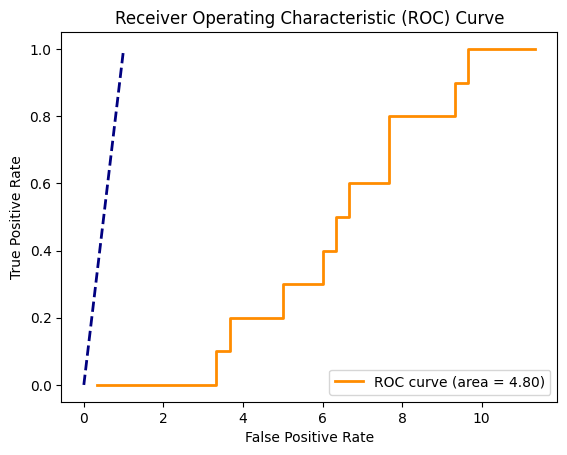

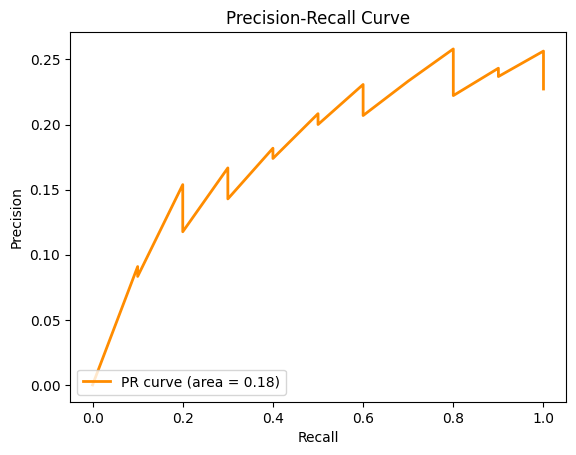

In [15]:
df = pd.read_csv("DATA (1).csv")
y = df[["GRADE"]]
X = df.drop(["GRADE", "STUDENT ID"], axis=1)
print(X)
print(y)


depth, mini = kfold_dtree(X, y, "GRADE", [100, 200, 300, 400], [2, 3, 4, 5])

X_train, X_test, y_train, y_test = my_train_test_split(X, y)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()


model = DecisionTree(max_depth=depth, min_samples_split=mini)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


conf_matrix = my_confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", conf_matrix)


TP = int(conf_matrix[0][0])
FP = int(conf_matrix[0][1])
FN = int(conf_matrix[1][0])
TN = int(conf_matrix[1][1])

if (TP + FP + FN + TN):
    print("Accuracy:", (TP + TN) / (TP + FP + FN + TN))
if (TP + FP):
    print("Precision:", (TP) / (TP + FP))
if (TP + FN):
    print("Recall:", (TP) / (TP + FN))
if (FP + TN):
    print("False positive rate:", FP / (FP + TN))
if(TN + FP):
    print("Specificity:", TN / (TN + FP))

fpr, tpr = auc_roc(y_test, y_pred)
roc_auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

recall, precision = auc_pr(y_test, y_pred)
pr_auc = np.trapz(precision, recall)
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()